In [ ]:
"""
This model simplify the hidden_size 
hidden_size = 192
"""

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
torch.set_printoptions(precision=6)


In [2]:
raw_data_A = pd.read_csv('data/data_A.csv')
raw_data_B = pd.read_csv('data/data_B.csv')
raw_data_C = pd.read_csv('data/data_C.csv')

In [3]:
data_A = raw_data_A.select_dtypes(include=[np.number])
data_B = raw_data_B.select_dtypes(include=[np.number])
data_C = raw_data_C.select_dtypes(include=[np.number])

In [4]:
scaler_1 = MinMaxScaler()
scaler_2 = MinMaxScaler()
scaler_3 = MinMaxScaler()

In [5]:
split_up_index = int(len(data_A)*0.8)

In [6]:
scaled_train_data_A = scaler_1.fit_transform(data_A[:split_up_index].values)
scaled_train_data_B = scaler_2.fit_transform(data_B[:split_up_index].values)
scaled_train_data_C = scaler_3.fit_transform(data_C[:split_up_index].values)

In [7]:
scaled_test_data_A = scaler_1.transform(data_A[split_up_index:].values)
scaled_test_data_B = scaler_2.transform(data_B[split_up_index:].values)
scaled_test_data_C = scaler_3.transform(data_C[split_up_index:].values)

In [8]:
scaled_train_data_C[13:]

array([[0.        ],
       [0.03059766],
       [0.04546754],
       [0.03116957],
       [0.04175007],
       [0.04832714],
       [0.0303117 ],
       [0.02716614],
       [0.06376894],
       [0.25850729],
       [0.7718044 ],
       [0.01201029],
       [0.01744352],
       [0.06948813],
       [0.05890764],
       [0.04746926],
       [0.05204461],
       [0.0577638 ],
       [0.06434086],
       [0.06577066],
       [0.11752931],
       [0.31484129],
       [0.8204175 ],
       [0.03059766],
       [0.02545039],
       [0.07063197],
       [0.08321418],
       [0.07006005],
       [0.08492994],
       [0.07863883],
       [0.07720904],
       [0.07720904],
       [0.11924507],
       [0.35859308],
       [0.86931656],
       [0.03688876],
       [0.04603946],
       [0.08979125],
       [0.08178439],
       [0.02659422],
       [0.07806691],
       [0.08607378],
       [0.0852159 ],
       [0.08407206],
       [0.14812697],
       [0.4077781 ],
       [1.        ],
       [0.044

In [9]:
def create_sequences_torch(data_A, data_B, data_C, min_length=12):
    output_seq = []
    target = []
    
    for x in range(min_length, len(data_A) - 1):
        inner_seq = torch.tensor(np.column_stack((
            data_A[:x], 
            data_B[:x], 
            data_C[:x]
        )), dtype=torch.float)
        
        output_seq.append(inner_seq)
        target.append(data_C[x + 1])  

    padded_seq = torch.nn.utils.rnn.pad_sequence(output_seq, batch_first=True, padding_value=0)

    return padded_seq, torch.tensor(target, dtype=torch.float32)

In [10]:
train_seq, train_targets = create_sequences_torch(scaled_train_data_A, scaled_train_data_B, scaled_train_data_C)
test_seq, test_targets = create_sequences_torch(scaled_test_data_A, scaled_test_data_B, scaled_test_data_C)

C:\Users\tongc\AppData\Local\Temp\ipykernel_26184\998990354.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  return padded_seq, torch.tensor(target, dtype=torch.float32)


In [11]:
print(train_seq.shape)
print(train_targets.shape)

torch.Size([297, 308, 3])
torch.Size([297, 1])


In [12]:
from torch.utils.data import DataLoader, Dataset

def get_lengths(padded_sequences):
        mask = (padded_sequences.abs().sum(dim=2) > 0).int()
        lengths = mask.sum(dim=1) 
        return lengths


class PreprocessedDataset(Dataset):
    def __init__(self, padded_sequences, labels):
        self.padded_sequences = padded_sequences 
        self.labels = labels  
        self.lengths = get_lengths(padded_sequences)  

    def __len__(self):
        return len(self.padded_sequences)

    def __getitem__(self, idx):
        return self.padded_sequences[idx], self.lengths[idx], self.labels[idx]

    
    
def collate_fn(batch):
    sequences, lengths, labels = zip(*batch) 

    sequences = torch.stack(sequences)
    lengths = torch.tensor(lengths)
    labels = torch.tensor(labels)

    lengths, sort_idx = lengths.sort(descending=True)
    sorted_sequences = sequences[sort_idx]
    sorted_labels = labels[sort_idx]

    _, original_order = sort_idx.sort()

    return sorted_sequences, lengths, sorted_labels, original_order

train_set = PreprocessedDataset(train_seq, train_targets)
test_set = PreprocessedDataset(test_seq, test_targets)

train_loader = DataLoader(train_set, 
                        batch_size=64, 
                        shuffle=False,
                        collate_fn=collate_fn) 

test_loader = DataLoader(test_set, 
                       batch_size=64, 
                       shuffle=False,
                       collate_fn=collate_fn) 

In [13]:
for batch in train_loader:
    sequences, lengths, labels, _ = batch
    print(f"Batch shapes - Sequences: {sequences.shape}, Labels: {labels.shape}")
    break

Batch shapes - Sequences: torch.Size([64, 308, 3]), Labels: torch.Size([64])


In [14]:
import torch.nn as nn
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, bidirectional):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        fc_input_size = hidden_size * 2 if bidirectional else hidden_size
        self.lstm = nn.LSTM(input_size, 
                          hidden_size, 
                          num_layers, 
                          batch_first=True,
                          dropout=dropout,
                        bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(fc_input_size, 1)


    def forward(self, x, lengths, original_order=None):

        lengths = lengths.cpu()
        
        packed_input = nn.utils.rnn.pack_padded_sequence(
            x, 
            lengths, 
            batch_first=True, 
            enforce_sorted=True
        )
        

        num_directions = 2 if self.lstm.bidirectional else 1
        h0 = torch.zeros(self.num_layers * num_directions, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * num_directions, x.size(0), self.hidden_size).to(x.device)
    
        
        packed_out, (hn, cn) = self.lstm(packed_input, (h0, c0))
        
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
        
        out = self.dropout(out)
        
        last_seq_idxs = lengths - 1
        out = out[torch.arange(out.shape[0]), last_seq_idxs]
        
        if original_order is not None:
            out = out[original_order]
        
        
        out = self.fc(out)
        #out = self.out(out)
        return out.squeeze(1)


In [15]:
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.optim.lr_scheduler import StepLR
from torch import optim


input_size = 3 
hidden_size = 192
num_layers = 3
dropout = 0.6
learning_rate = 0.001
num_epochs = 200

model = LSTMModel(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout=dropout,
    bidirectional= True
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)


def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, scheduler):
    model.train()
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_samples = 0
        
        for batch_idx, (sorted_sequences, lengths, sorted_labels, original_order) in enumerate(train_loader):
            sequences = sorted_sequences.to(device)
            labels = sorted_labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(sequences, lengths)
            loss = criterion(outputs.view(-1), labels.view(-1).float())
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * sequences.size(0)
            total_samples += sequences.size(0)
        
        epoch_train_loss = running_loss / total_samples
        train_losses.append(epoch_train_loss)
        
        model.eval()
        test_loss = 0.0
        total_test_samples = 0
        
        with torch.no_grad():
            for sequences, lengths, targets, _ in test_loader:
                sequences = sequences.to(device)
                targets = targets.to(device)
                
                outputs = model(sequences, lengths)
                loss = criterion(outputs.view(-1), targets.view(-1).float())
                
                test_loss += loss.item() * sequences.size(0)
                total_test_samples += sequences.size(0)
        

        epoch_test_loss = test_loss / total_test_samples
        test_losses.append(epoch_test_loss)
        if (epoch+1)%50 == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Epoch: {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} | "
              f"Test Loss: {epoch_test_loss:.4f} |"
                f"LR: {current_lr}")
        scheduler.step()
    return train_losses, test_losses

class Case(Enum):
    test = "Test"
    train = "Train"

def evaluate_model(model, test_loader, criterion, case):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for sequences, seq_lengths, targets, _ in test_loader: 
            sequences = sequences.to(device)
            targets = targets.to(device)
            
            outputs = model(sequences, seq_lengths)
            loss = criterion(outputs.view(-1), targets.view(-1).float())
            total_loss += loss.item()
            
            preds = outputs.cpu().numpy()
            targets_np = targets.cpu().numpy()
   
            all_preds.extend(preds.flatten())
            all_targets.extend(targets_np.flatten())

    
    avg_loss = total_loss / len(test_loader)
    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)
    
    
    print(f'{case.value} Loss: {avg_loss:.4f} | MSE: {mse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}')
    return all_preds, all_targets

def plot_loss_curves(train_losses, test_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Training and Test Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    

def plot_result(predictions, targets, title='Train vs Actual'):
    plt.figure(figsize=(12, 6))
    
    # Create an index array for plotting
    idx = np.arange(len(targets))
    
    # Plot both arrays
    plt.plot(idx, targets, label='Actual Values', alpha=0.7)
    plt.plot(idx, predictions, label='Predicted Values', alpha=0.5)
    
    # Add plot formatting
    plt.title(f'{title}')
    plt.xlabel('Sequence Index')
    plt.ylabel('Target Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Epoch: 50/200 | Train Loss: 0.0089 | Test Loss: 0.0271 |LR: 0.001
Epoch: 100/200 | Train Loss: 0.0025 | Test Loss: 0.0111 |LR: 0.0005
Epoch: 150/200 | Train Loss: 0.0014 | Test Loss: 0.0097 |LR: 0.00025
Epoch: 200/200 | Train Loss: 0.0018 | Test Loss: 0.0088 |LR: 0.000125


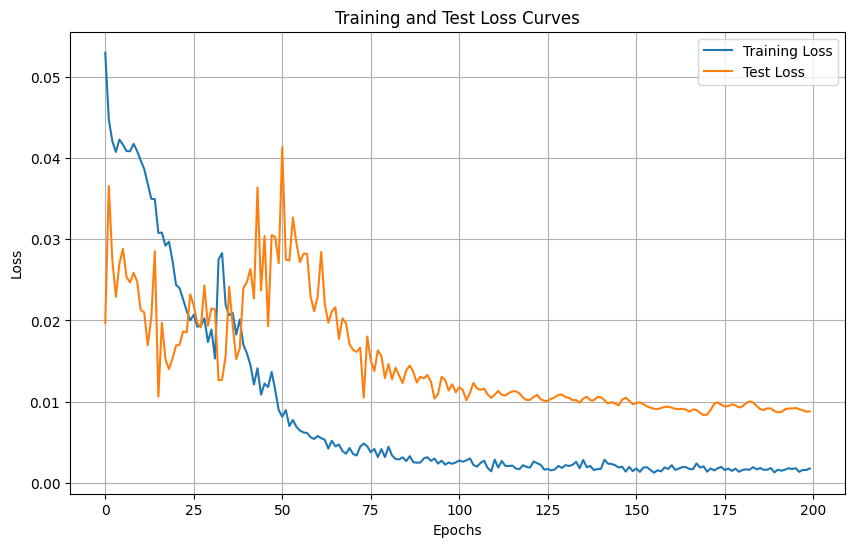

Train Loss: 0.0004 | MSE: 0.0004 | MAE: 0.0145 | R²: 0.9894
Test Loss: 0.0045 | MSE: 0.0088 | MAE: 0.0605 | R²: 0.5476


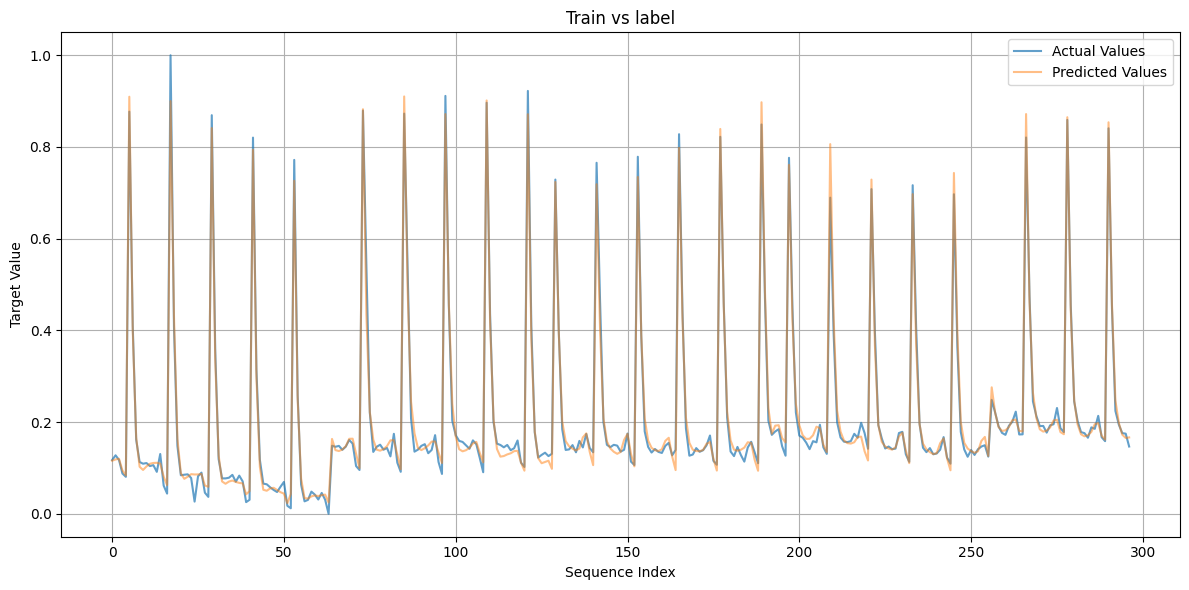

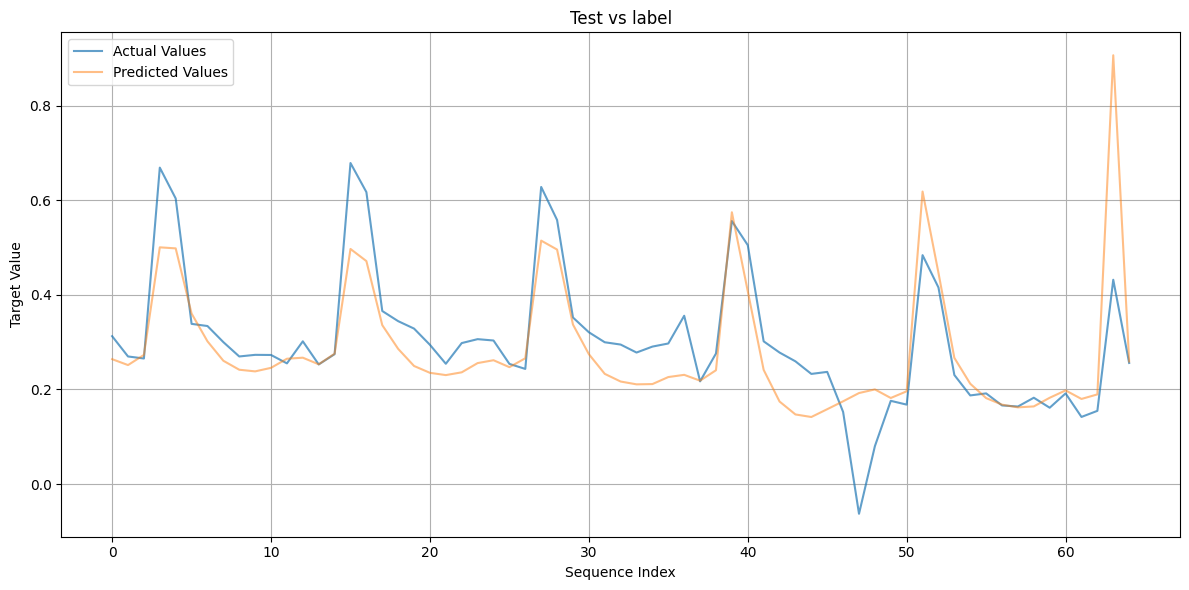

In [16]:
# Train the model
train_losses,test_losses = train_model(model, train_loader,test_loader, criterion, optimizer, num_epochs,scheduler)

plot_loss_curves(train_losses,test_losses)

# Evaluate the model
train_preds, train_targets = evaluate_model(model, train_loader, criterion, Case.train)
test_pred, actual_Label = evaluate_model(model, test_loader, criterion, Case.test)

# Plot results
plot_result(train_preds,train_targets, title="Train vs label")
plot_result(test_pred, actual_Label, title="Test vs label")